# AMV Historical Data

In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
import math

In [2]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('AMV Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [15]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,40400.0,39300.0,41000.0,38900.0,154530,0.0280
1,05/30/2024,39300.0,38800.0,39800.0,38500.0,76570,-0.0051
2,05/29/2024,39500.0,39900.0,39900.0,38300.0,107350,0.0051
3,05/28/2024,39300.0,38600.0,39500.0,38200.0,61630,0.0181
4,05/27/2024,38600.0,35200.0,39900.0,35200.0,133260,0.0604
...,...,...,...,...,...,...,...
1307,03/07/2019,11589.7,11842.2,11842.2,11224.9,240150,0.0024
1308,03/06/2019,11561.6,11309.1,11589.7,11309.1,292910,0.0198
1309,03/05/2019,11337.1,11224.9,11365.2,10888.1,308000,0.0100
1310,03/04/2019,11224.9,11056.5,11477.4,11056.5,296000,0.0336


In [16]:
df1

0       40400.0
1       39300.0
2       39500.0
3       39300.0
4       38600.0
         ...   
1307    11589.7
1308    11561.6
1309    11337.1
1310    11224.9
1311    10860.1
Name: Price, Length: 1312, dtype: float64

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [8]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0847 - val_loss: 0.0114
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0102 - val_loss: 0.0029
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - val_loss: 7.1460e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - val_loss: 4.3268e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0040 - val_loss: 6.6505e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0036 - val_loss: 4.6582e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0042 - val_loss: 0.0010
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0041 - val_loss: 7.4896e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0043 - val_loss: 4.8075e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0031 - val_loss: 5.5455e-04
Epoch 12/100
18/18 ━━━━━

In [10]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


In [11]:
# 11 Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 298.00186
MAPE trên tập test là: 1.743903011083603 %
MSLE trên tập test là: 0.00046629237


In [12]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.57633305]
73
1 day input [0.50221572 0.50221572 0.49810407 0.47343415 0.48165745 0.47960163
 0.47960163 0.47960163 0.48576911 0.49193659 0.49399242 0.48576911
 0.50838321 0.51048472 0.51459637 0.53309882 0.52487551 0.54954543
 0.56603774 0.54543378 0.51459637 0.52281968 0.52693134 0.53721047
 0.52898716 0.51870803 0.50632738 0.50221572 0.52076385 0.52898716
 0.53309882 0.53104299 0.51459637 0.51459637 0.49810407 0.51254055
 0.52487551 0.53104299 0.52898716 0.52898716 0.53309882 0.53721047
 0.53515464 0.52487551 0.52281968 0.52487551 0.49810407 0.51459637
 0.51459637 0.54132213 0.54543378 0.55160126 0.54543378 0.54543378
 0.53721047 0.55781443 0.5557586  0.54748961 0.55365709 0.54954543
 0.54954543 0.54543378 0.53515464 0.52693134 0.52487551 0.52487551
 0.52281968 0.54337795 0.53515464 0.5557586  0.57220522 0.57633305]
1 day output [[0.5824949]]
2 day input [0.50221572 0.49810407 0.47343415 0.48165745 0.47960163 0.47960163
 0.47960163 0.48576911 0.49193659 0.49399242 0.48576911 0.508

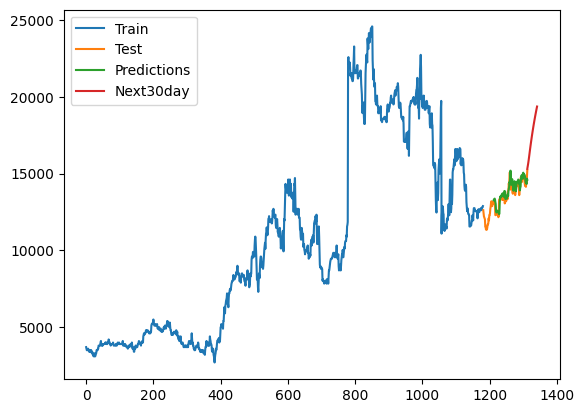

In [13]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DHT Historical Data

In [14]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('DHT Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Áp dụng hàm chuyển đổi cho cột "Vol."
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [17]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,40400.0,39300.0,41000.0,38900.0,154530,0.0280
1,05/30/2024,39300.0,38800.0,39800.0,38500.0,76570,-0.0051
2,05/29/2024,39500.0,39900.0,39900.0,38300.0,107350,0.0051
3,05/28/2024,39300.0,38600.0,39500.0,38200.0,61630,0.0181
4,05/27/2024,38600.0,35200.0,39900.0,35200.0,133260,0.0604
...,...,...,...,...,...,...,...
1307,03/07/2019,11589.7,11842.2,11842.2,11224.9,240150,0.0024
1308,03/06/2019,11561.6,11309.1,11589.7,11309.1,292910,0.0198
1309,03/05/2019,11337.1,11224.9,11365.2,10888.1,308000,0.0100
1310,03/04/2019,11224.9,11056.5,11477.4,11056.5,296000,0.0336


In [18]:
df1

0       40400.0
1       39300.0
2       39500.0
3       39300.0
4       38600.0
         ...   
1307    11589.7
1308    11561.6
1309    11337.1
1310    11224.9
1311    10860.1
Name: Price, Length: 1312, dtype: float64

In [19]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [20]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [21]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [22]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [23]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [24]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 0.0347 - val_loss: 0.0059
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038 - val_loss: 0.0029
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0012 - val_loss: 9.9538e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 9.9525e-04 - val_loss: 8.6737e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 8.8520e-04 - val_loss: 7.8231e-04
Epoch 12/100
18/18 ━━━━━━━━━━━━━

In [26]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [27]:
# 11 Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 451.9887
MAPE trên tập test là: 3.1982004642486572 %
MSLE trên tập test là: 0.0017312334


In [28]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.06383816]
73
1 day input [0.02587697 0.01293848 0.00995293 0.01592404 0.01592404 0.01094596
 0.01194222 0.01592404 0.0189096  0.02289141 0.01194222 0.01592404
 0.01194222 0.0189096  0.02089889 0.0189096  0.0189096  0.0189096
 0.01592404 0.03284111 0.01393152 0.01592404 0.02289141 0.0189096
 0.02488071 0.02089889 0.02985556 0.03881545 0.02985556 0.03582667
 0.04080475 0.03483363 0.03401793 0.03763864 0.0385414  0.02677973
 0.02497098 0.02587697 0.02497098 0.02225625 0.02225625 0.0141153
 0.02316224 0.02316224 0.024065   0.02225625 0.01954153 0.0313032
 0.02316224 0.02949445 0.03492391 0.02768571 0.0313032  0.03311517
 0.03220918 0.04125613 0.0385414  0.04668558 0.04397085 0.04125613
 0.05030307 0.05573253 0.05482977 0.05030307 0.05573253 0.05392378
 0.07111491 0.07020892 0.06297072 0.05935324 0.04759157 0.06383816]
1 day output [[0.0628375]]
2 day input [0.01293848 0.00995293 0.01592404 0.01592404 0.01094596 0.01194222
 0.01592404 0.0189096  0.02289141 0.01194222 0.01592404 0.0119422

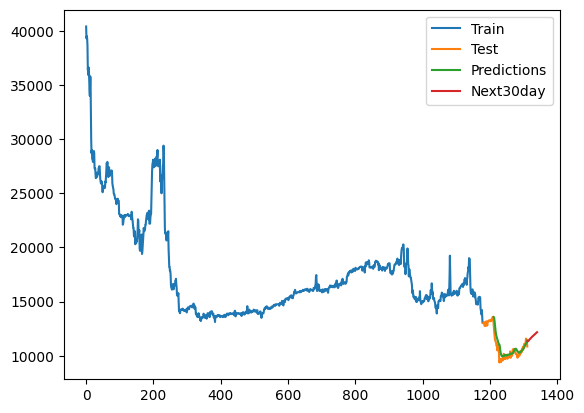

In [29]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()

# DP3 Historical Data

In [31]:
# 2. Đọc file csv và gắn index với giá Close
data = pd.read_csv('DP3 Historical Data.csv')

# Tiền xử lí dữ liệu
# Hàm chuyển đổi "Vol." từ chuỗi sang số
def convert_volume_to_number(volume_str):
    if volume_str[-1] == 'K':
        return int(float(volume_str[:-1]) * 1000)
    elif volume_str[-1] == 'M':
        return int(float(volume_str[:-1]) * 1000000)
    elif volume_str[-1] == 'B':
        return int(float(volume_str[:-1]) * 1000000000)
    else:
        return int(volume_str)

# Hàm chuyển đổi "Change %" từ chuỗi sang số
def convert_change_to_number(change_str):
    new_change = float(change_str.strip('%')) / 100
    return new_change

# Áp dụng hàm chuyển đổi cho cột "Change %"
data["Change %"] = data["Change %"].apply(convert_change_to_number)

# Hàm chuyển giá từ chuỗi sang số
def convert_str_to_number(str):
    return float(str.replace(',', ''))

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'] = data['Price'].apply(convert_str_to_number)
data['Open'] = data['Open'].apply(convert_str_to_number)
data['High'] = data['High'].apply(convert_str_to_number)
data['Low'] = data['Low'].apply(convert_str_to_number)

data

df1=data.reset_index()['Price']

In [32]:
data

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,61600.0,61500.0,61700.0,61500.0,10.51K,0.0016
1,05/30/2024,61500.0,61000.0,61500.0,60700.0,5.11K,0.0082
2,05/29/2024,61000.0,62000.0,62000.0,61000.0,7.30K,0.0000
3,05/28/2024,61000.0,61000.0,61800.0,60900.0,7.90K,0.0016
4,05/27/2024,60900.0,61700.0,61700.0,60900.0,12.67K,-0.0016
...,...,...,...,...,...,...,...
1132,03/07/2019,76300.0,75000.0,76900.0,74700.0,11.57K,0.0214
1133,03/06/2019,74700.0,74100.0,75000.0,74000.0,3.81K,0.0040
1134,03/05/2019,74400.0,75000.0,75000.0,74000.0,7.33K,-0.0067
1135,03/04/2019,74900.0,73800.0,75200.0,73800.0,8.34K,0.0149


In [33]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
# 4. Chia train test
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

In [35]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [36]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [37]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [38]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(time_step, 1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

c:\Users\miynzi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [39]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0706 - val_loss: 0.0048
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0115 - val_loss: 0.0024
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0047 - val_loss: 0.0016
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - val_loss: 9.2451e-04
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0040 - val_loss: 8.8964e-04
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0039 - val_loss: 8.0830e-04
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0039 - val_loss: 7.2494e-04
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0039 - val_loss: 5.6937e-04
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0038 - val_loss: 6.3081e-04
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0040 - val_loss: 4.9978e-04
Epoch 12/100
16/16 ━━━━━

In [40]:
# 10. Dự báo dữ liệu test
y_pred=model.predict(X_test)

y_pred_new = scaler.inverse_transform(y_pred.reshape(1, -1))
y_test_new = scaler.inverse_transform(np.array([y_test], dtype=np.float32))

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


In [41]:
# 11 Tính toán RMSE, MAPE và MSLE

test_score_rmse = np.sqrt(mean_squared_error(y_test_new, y_pred_new))
test_score_mape = mean_absolute_percentage_error(y_test_new, y_pred_new) * 100
test_score_msle = mean_squared_log_error(y_test_new, y_pred_new)

print('RMSE trên tập test là:', test_score_rmse)
print('MAPE trên tập test là:', test_score_mape, '%')
print('MSLE trên tập test là:', test_score_msle)

RMSE trên tập test là: 1336.0717
MAPE trên tập test là: 1.333449874073267 %
MSLE trên tập test là: 0.00033945372


In [42]:
# 12. Dự báo 30 ngày tiếp theo
x_input=test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=x_input.shape[1]
i=0
while(i<30):
    if(len(temp_input)>x_input.shape[1]):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.37180603]
55
1 day input [0.29814037 0.2972834  0.30585312 0.31099494 0.2972834  0.30156826
 0.30756706 0.3152798  0.31870769 0.31442283 0.31442283 0.34013197
 0.34013197 0.33756106 0.34316565 0.33276202 0.33996058 0.33996058
 0.34396264 0.40183392 0.40269089 0.40783272 0.41211758 0.41725941
 0.40011998 0.39069329 0.39412118 0.39840603 0.41297455 0.40868969
 0.40868969 0.41725941 0.38983632 0.39155026 0.39583512 0.38298055
 0.38298055 0.38298055 0.38298055 0.38298055 0.38555146 0.3872654
 0.3872654  0.38212358 0.38298055 0.3872654  0.39583512 0.39669209
 0.38555146 0.37183992 0.369269   0.37355386 0.36412717 0.37180603]
1 day output [[0.37161297]]
2 day input [0.2972834  0.30585312 0.31099494 0.2972834  0.30156826 0.30756706
 0.3152798  0.31870769 0.31442283 0.31442283 0.34013197 0.34013197
 0.33756106 0.34316565 0.33276202 0.33996058 0.33996058 0.34396264
 0.40183392 0.40269089 0.40783272 0.41211758 0.41725941 0.40011998
 0.39069329 0.39412118 0.39840603 0.41297455 0.40868969 0.408

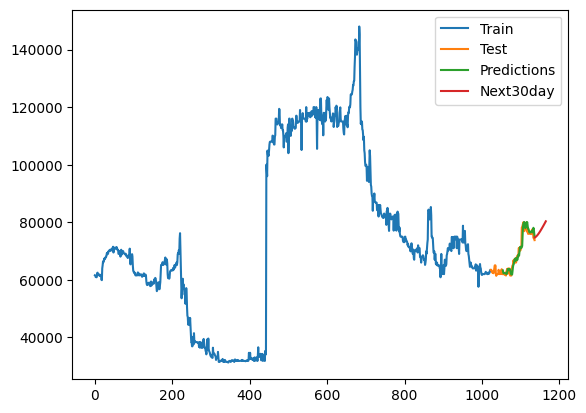

In [43]:
# 13.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(y_pred))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions','Next30day'])
plt.show()